In [1]:
import os
import sys
import glob
from collections import defaultdict, Counter
from functools import reduce, partial
from multiprocessing import Pool
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from scipy.stats import bootstrap, binom_test
from statsmodels.stats.multitest import multipletests
from scipy.spatial.distance import cosine, euclidean
from Bio import SeqIO
import tqdm

from pymutspec.draw import plot_mutspec12, plot_mutspec192
from pymutspec.annotation import rev_comp, CodonAnnotation, transcriptor, mutations_summary
from pymutspec.io import read_rates
from pymutspec.constants import possible_sbs192, possible_sbs12

%matplotlib inline

In [2]:
def complete_sbs192_columns(df: pd.DataFrame):
    df = df.copy()
    if len(df.columns) != 192:
        for sbs192 in set(possible_sbs192).difference(df.columns.values):
            df[sbs192] = 0.
    df = df[possible_sbs192]
    return df


def jackknife_spectra_sampling(obs: pd.DataFrame, exp: pd.DataFrame, frac=0.5, n=1000):
    if len(obs.columns) == 192 and (obs.columns == possible_sbs192).all() and (exp.columns == possible_sbs192).all():
        assert obs.index.names == ["RefNode", "AltNode"]
        assert exp.index.names == ["Node"]
        altnodes  = obs.index.get_level_values(1).values
        obs_edges = obs
        freqs_nodes = exp
        obs_edges.index = obs_edges.index.reorder_levels(order=["AltNode", "RefNode"])
        freqs_nodes.index.name = "RefNode"
    else:
        altnodes = obs.AltNode.unique()
        obs_edges = obs.groupby(["AltNode", "RefNode", "Mut"]).ProbaFull.sum().unstack()
        obs_edges = complete_sbs192_columns(obs_edges)
        freqs_nodes = exp.rename(columns={"Node": "RefNode"}).groupby(["RefNode", "Mut"]).Proba.sum().unstack()
        freqs_nodes = complete_sbs192_columns(freqs_nodes)

    edges_sample_size = int(len(altnodes) * frac)
    spectra = []
    for _ in range(n):
        altnodes_sample = np.random.choice(altnodes, edges_sample_size, False)
        obs_sample = obs_edges.loc[altnodes_sample].reset_index(0, drop=True)
        exp_sample = freqs_nodes.loc[obs_sample.index]
        
        obs_sample_cnt = obs_sample.sum()
        exp_sample_cnt = exp_sample.sum()

        assert (obs_sample_cnt.index == exp_sample_cnt.index).all()

        sample_spectra = obs_sample_cnt / exp_sample_cnt
        spectra.append(sample_spectra)

    return pd.DataFrame(spectra).fillna(0.)


def collapse_sbs192(df: pd.DataFrame, to=12):
    assert (df.columns == possible_sbs192).all()
    df = df.copy()
    if to == 12:
        for sbs192 in possible_sbs192:
            sbs12 = sbs192[2:5]
            if sbs12 in df.columns.values:
                df[sbs12] += df[sbs192]
            else:
                df[sbs12] = df[sbs192]

        return df[possible_sbs12]
    else:
        raise NotImplementedError()


def calc_edgewise_spectra(obs: pd.DataFrame, exp: pd.DataFrame, nmtypes_cutoff=16, nobs_cuttof=20, collapse_to_12=False, scale=True):
    if len(obs.columns) == 192 and (obs.columns == possible_sbs192).all() and (exp.columns == possible_sbs192).all():
        assert obs.index.names == ["RefNode", "AltNode"]
        assert exp.index.names == ["Node"]
        obs_edges = obs
        freqs_nodes = exp
        freqs_nodes.index.name = "RefNode"
    else:
        obs_edges = obs.groupby(["RefNode", "AltNode", "Mut"]).ProbaFull.sum().unstack()
        obs_edges = complete_sbs192_columns(obs_edges)
        freqs_nodes = exp.groupby(["Node", "Mut"]).Proba.sum().unstack()
        freqs_nodes.index.name = "RefNode"
        freqs_nodes = complete_sbs192_columns(freqs_nodes)

    if not collapse_to_12:
        obs_edges = obs_edges[((obs_edges > 0).sum(axis=1) >= nmtypes_cutoff) & (obs_edges.sum(axis=1) > nobs_cuttof)]
    
    edges_df = obs_edges.index.to_frame(False)

    freqs_edges = edges_df.merge(freqs_nodes, on="RefNode")\
        .set_index(["RefNode", "AltNode"])[possible_sbs192]
    
    assert (obs_edges.columns == freqs_edges.columns).all()
    assert (obs_edges.index == freqs_edges.index).all()

    if collapse_to_12:
        obs_edges   = collapse_sbs192(obs_edges, to=12)
        freqs_edges = collapse_sbs192(freqs_edges, to=12)

    spectra = (obs_edges / freqs_edges).replace(np.inf, 0.).fillna(0.)
    if scale:
        spectra = (spectra.T / spectra.T.sum(axis=0)).T

    spectra = spectra.fillna(0)
    assert not (spectra == np.inf).any().any()
    assert not (spectra.isna()).any().any()
    return spectra


def assign_cat(p: float, interval=0.1):
    if interval < 0.01:
        raise NotImplementedError
    
    left = p // interval / (1 / interval)
    right = left + interval
    if interval >= 0.1:
        return f"{left:.1f}_{right:.1f}"
    else:
        return f"{left:.2f}_{right:.2f}"


def get_cossim(a: pd.DataFrame, b: pd.DataFrame):
    assert (a.columns == b.columns).all()
    
    common_index = a.index.intersection(b.index)
    if len(common_index) == 0:
        return pd.Series()
    
    a = a.loc[common_index]
    b = b.loc[common_index]

    dotprod = (a * b).sum(axis=1)
    a_norm = (a ** 2).sum(axis=1) ** 0.5
    b_norm = (b ** 2).sum(axis=1) ** 0.5
    cossim = dotprod / (a_norm * b_norm)
    return cossim

In [3]:
coda = CodonAnnotation(2)

## Random species trees

### 12  all sites

In [77]:
nmuttypes = 12
param_rates = "_all_positions"

data_rec  = []
data_gt  = []
for d in tqdm.tqdm(glob.glob("../data/alisim/spectra_reconstructed_sp" + param_rates + "/*")):
    elabel = d.split("/")[-1]
    path_to_rec = os.path.join(d, "mutspec_tables/ms{}{}_iqtree.tsv")
    path_to_gt = f"../data/alisim/spectra_groundtruth_sp{param_rates}/{elabel}/mutspec{nmuttypes}.tsv"
    
    if not os.path.exists(path_to_gt):
        # print(f"{elabel}:\n\t'{path_to_gt}' doesn't exist")
        pass
    elif not os.path.exists(path_to_rec.format(nmuttypes, "syn")):
        # print(f"{elabel}:\n\t'{path_to_rec.format('syn')}' doesn't exist")
        pass
    else:
        rec = pd.concat([
            pd.read_csv(path_to_rec.format(nmuttypes, "syn"), sep="\t").assign(Label="syn"),
            pd.read_csv(path_to_rec.format(nmuttypes, "all"), sep="\t").assign(Label="all"),
        ], ignore_index=True)
        gt = pd.read_csv(path_to_gt, sep="\t")
        gt = gt[gt.Label.isin(["all", "syn"])]\
            .groupby(["Label", "Mut"]).agg({"ObsNum": np.sum, "ExpNum": np.mean})
        gt["MutSpec"] = gt["ObsNum"]  / gt["ExpNum"]
        gt["MutSpec"] = gt["MutSpec"] / gt["MutSpec"].sum()

        rec = rec.assign(RawCond=elabel)
        gt = gt.reset_index().assign(RawCond=elabel)[rec.columns]
        data_rec.append(rec)
        data_gt.append(gt)

        # cossim = 1 - cosine(spectra.MutSpec_rec, spectra.MutSpec_gt)
        # eucdist = euclidean(spectra.MutSpec_rec, spectra.MutSpec_gt)
        # mdl, tree, aln, _, replica = elabel.split("_")
        # data.append((mdl, tree, aln, replica, cossim, eucdist, elabel))

100%|██████████| 800/800 [00:20<00:00, 39.01it/s]


In [78]:
df_rec = pd.concat(data_rec)
df_gt = pd.concat(data_gt)

_indexes = ["RawCond", "Label", "Mut"]
both_spectra = df_rec.merge(df_gt, on=_indexes, suffixes=["_rec", "_gt"])
both_spectra = both_spectra[_indexes + ['ObsNum_gt', 'ObsNum_rec','ExpNum_gt', 'ExpNum_rec', 'MutSpec_gt', 'MutSpec_rec']]

_df = both_spectra[
    (both_spectra.ExpNum_rec > 1) & (both_spectra.ExpNum_gt > 1) &
    (both_spectra.ObsNum_rec > 1) & (both_spectra.ObsNum_gt > 1)
].set_index(_indexes)

spectra_rec_wide = _df.MutSpec_rec.unstack().fillna(0.)
spectra_gt_wide = _df.MutSpec_gt.unstack().fillna(0.)

# obs_rec_wide = df_rec.set_index(["RawCond", "Label", "Mut"]).ObsNum.unstack().fillna(0.)
# obs_gt_wide = df_gt.set_index(["RawCond", "Label", "Mut"]).ObsNum.unstack().fillna(0.)

In [79]:
sims = get_cossim(spectra_gt_wide, spectra_rec_wide).rename("CosSim").reset_index()
sims["Cond"] = sims.RawCond.str.replace("_replica_\d{1,2}", "")
sims.head()

,RawCond,Label,CosSim,Cond
0,12.12_1000_cytb_replica_0,all,0.999987,12.12_1000_cytb
1,12.12_1000_cytb_replica_0,syn,0.999428,12.12_1000_cytb
2,12.12_1000_cytb_replica_1,all,0.999980,12.12_1000_cytb
3,12.12_1000_cytb_replica_1,syn,0.999834,12.12_1000_cytb
4,12.12_1000_cytb_replica_10,all,0.999983,12.12_1000_cytb


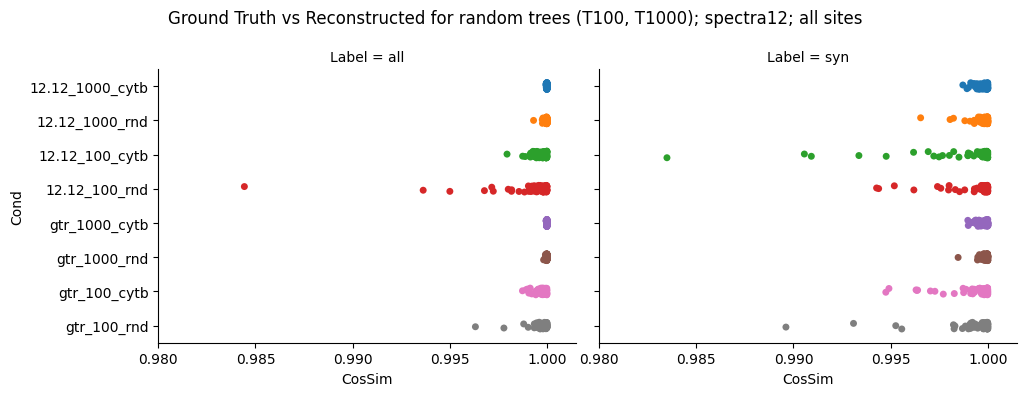

In [80]:
g = sns.catplot(x="CosSim", y="Cond", col="Label",
                data=sims, kind="strip",
                height=4, aspect=1.3);
g.fig.suptitle(f"Ground Truth vs Reconstructed for random trees (T100, T1000); spectra{nmuttypes}; all sites")
g.fig.subplots_adjust(top=0.83)
plt.xlim(0.98, 1.0015)
plt.xticks(np.linspace(0.98, 1, 5))
g.savefig(f"../figures/alisim/cossim_all_sites{nmuttypes}.pdf")
plt.show()

### 12 excluding inv sites

In [81]:
nmuttypes = 12
param_rates = ""

data_rec  = []
data_gt  = []
for d in tqdm.tqdm(glob.glob("../data/alisim/spectra_reconstructed_sp" + param_rates + "/*")):
    elabel = d.split("/")[-1]
    path_to_rec = os.path.join(d, "mutspec_tables/ms{}{}_iqtree.tsv")
    path_to_gt = f"../data/alisim/spectra_groundtruth_sp{param_rates}/{elabel}/mutspec{nmuttypes}.tsv"
    
    if not os.path.exists(path_to_gt):
        # print(f"{elabel}:\n\t'{path_to_gt}' doesn't exist")
        pass
    elif not os.path.exists(path_to_rec.format(nmuttypes, "syn")):
        # print(f"{elabel}:\n\t'{path_to_rec.format('syn')}' doesn't exist")
        pass
    else:
        rec = pd.concat([
            pd.read_csv(path_to_rec.format(nmuttypes, "syn"), sep="\t").assign(Label="syn"),
            pd.read_csv(path_to_rec.format(nmuttypes, "all"), sep="\t").assign(Label="all"),
        ], ignore_index=True)
        gt = pd.read_csv(path_to_gt, sep="\t")
        gt = gt[gt.Label.isin(["all", "syn"])]\
            .groupby(["Label", "Mut"]).agg({"ObsNum": np.sum, "ExpNum": np.mean})
        gt["MutSpec"] = gt["ObsNum"]  / gt["ExpNum"]
        gt["MutSpec"] = gt["MutSpec"] / gt["MutSpec"].sum()

        rec = rec.assign(RawCond=elabel)
        gt = gt.reset_index().assign(RawCond=elabel)[rec.columns]
        data_rec.append(rec)
        data_gt.append(gt)

        # cossim = 1 - cosine(spectra.MutSpec_rec, spectra.MutSpec_gt)
        # eucdist = euclidean(spectra.MutSpec_rec, spectra.MutSpec_gt)
        # mdl, tree, aln, _, replica = elabel.split("_")
        # data.append((mdl, tree, aln, replica, cossim, eucdist, elabel))

  0%|          | 3/800 [00:00<00:27, 28.69it/s]

100%|██████████| 800/800 [00:20<00:00, 39.69it/s]


In [82]:
df_rec = pd.concat(data_rec)
df_gt = pd.concat(data_gt)

_indexes = ["RawCond", "Label", "Mut"]
both_spectra = df_rec.merge(df_gt, on=_indexes, suffixes=["_rec", "_gt"])
both_spectra = both_spectra[_indexes + ['ObsNum_gt', 'ObsNum_rec','ExpNum_gt', 'ExpNum_rec', 'MutSpec_gt', 'MutSpec_rec']]

_df = both_spectra[
    (both_spectra.ExpNum_rec > 1) & (both_spectra.ExpNum_gt > 1) &
    (both_spectra.ObsNum_rec > 1) & (both_spectra.ObsNum_gt > 1)
].set_index(_indexes)

spectra_rec_wide = _df.MutSpec_rec.unstack().fillna(0.)
spectra_gt_wide = _df.MutSpec_gt.unstack().fillna(0.)

# obs_rec_wide = df_rec.set_index(["RawCond", "Label", "Mut"]).ObsNum.unstack().fillna(0.)
# obs_gt_wide = df_gt.set_index(["RawCond", "Label", "Mut"]).ObsNum.unstack().fillna(0.)

In [83]:
sims = get_cossim(spectra_gt_wide, spectra_rec_wide).rename("CosSim").reset_index()
sims["Cond"] = sims.RawCond.str.replace("_replica_\d{1,2}", "")
sims.head()

,RawCond,Label,CosSim,Cond
0,12.12_1000_cytb_replica_0,all,0.999975,12.12_1000_cytb
1,12.12_1000_cytb_replica_0,syn,0.999458,12.12_1000_cytb
2,12.12_1000_cytb_replica_1,all,0.998176,12.12_1000_cytb
3,12.12_1000_cytb_replica_1,syn,0.999250,12.12_1000_cytb
4,12.12_1000_cytb_replica_10,all,0.999961,12.12_1000_cytb


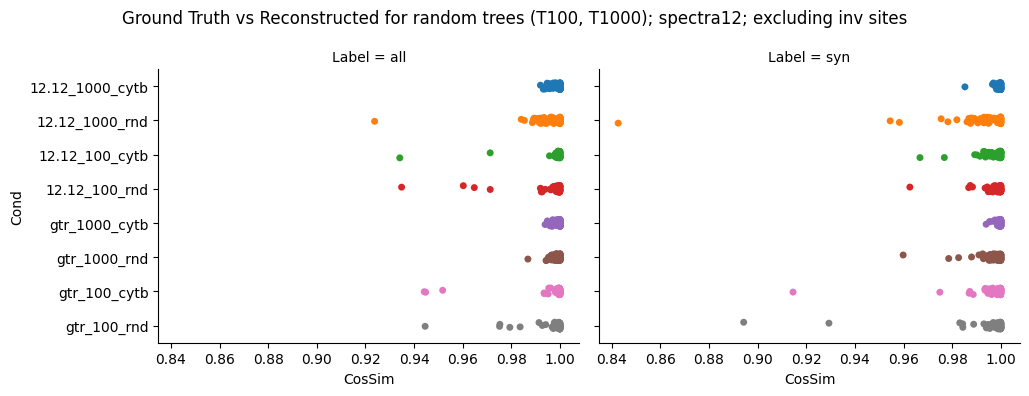

In [87]:
g = sns.catplot(x="CosSim", y="Cond", col="Label",
                data=sims, kind="strip",
                height=4, aspect=1.3);
g.fig.suptitle(f"Ground Truth vs Reconstructed for random trees (T100, T1000); spectra{nmuttypes}; excluding inv sites")
g.fig.subplots_adjust(top=0.83)
plt.xticks(np.linspace(0.84, 1, 9))
g.savefig(f"../figures/alisim/cossim_ex_cat2_sites{nmuttypes}.pdf")
plt.show()

In [88]:
cutoff = 0.95
sims[f"cossim > {cutoff}"] = sims.CosSim > cutoff
sims.groupby(["Cond", "Label"])[f"cossim > {cutoff}"].value_counts().unstack().fillna(0).T

Cond          12.12_1000_cytb        12.12_1000_rnd       12.12_100_cytb  \
Label                     all    syn            all   syn            all   
cossim > 0.95                                                              
False                     0.0    0.0            1.0   1.0            1.0   
True                    100.0  100.0           99.0  99.0           99.0   

Cond                 12.12_100_rnd        gtr_1000_cytb        gtr_1000_rnd  \
Label            syn           all    syn           all    syn          all   
cossim > 0.95                                                                 
False            0.0           1.0    0.0           0.0    0.0          0.0   
True           100.0          99.0  100.0         100.0  100.0        100.0   

Cond                 gtr_100_cytb       gtr_100_rnd        
Label            syn          all   syn         all   syn  
cossim > 0.95                                              
False            0.0          2.0   1.0         1.0   2.0  
True           100.0         98.0  99.0        99.0  98.0

### 192  all sites

In [90]:
nmuttypes = 192
param_rates = "_all_positions"

data_rec  = []
data_gt  = []
for d in tqdm.tqdm(glob.glob("../data/alisim/spectra_reconstructed_sp" + param_rates + "/*")):
    elabel = d.split("/")[-1]
    path_to_rec = os.path.join(d, "mutspec_tables/ms{}{}_iqtree.tsv")
    path_to_gt = f"../data/alisim/spectra_groundtruth_sp{param_rates}/{elabel}/mutspec{nmuttypes}.tsv"
    
    if not os.path.exists(path_to_gt):
        # print(f"{elabel}:\n\t'{path_to_gt}' doesn't exist")
        pass
    elif not os.path.exists(path_to_rec.format(nmuttypes, "syn")):
        # print(f"{elabel}:\n\t'{path_to_rec.format('syn')}' doesn't exist")
        pass
    else:
        rec = pd.concat([
            pd.read_csv(path_to_rec.format(nmuttypes, "syn"), sep="\t").assign(Label="syn"),
            pd.read_csv(path_to_rec.format(nmuttypes, "all"), sep="\t").assign(Label="all"),
        ], ignore_index=True)
        gt = pd.read_csv(path_to_gt, sep="\t")
        gt = gt[gt.Label.isin(["all", "syn"])]\
            .groupby(["Label", "Mut"]).agg({"ObsNum": np.sum, "ExpNum": np.mean})
        gt["MutSpec"] = gt["ObsNum"]  / gt["ExpNum"]
        gt["MutSpec"] = gt["MutSpec"] / gt["MutSpec"].sum()

        rec = rec.assign(RawCond=elabel)
        gt = gt.reset_index().assign(RawCond=elabel)[rec.columns]
        data_rec.append(rec)
        data_gt.append(gt)

        # cossim = 1 - cosine(spectra.MutSpec_rec, spectra.MutSpec_gt)
        # eucdist = euclidean(spectra.MutSpec_rec, spectra.MutSpec_gt)
        # mdl, tree, aln, _, replica = elabel.split("_")
        # data.append((mdl, tree, aln, replica, cossim, eucdist, elabel))

  0%|          | 0/800 [00:00<?, ?it/s]

100%|██████████| 800/800 [02:50<00:00,  4.68it/s]


In [94]:
df_rec = pd.concat(data_rec)
df_gt = pd.concat(data_gt)

_indexes = ["RawCond", "Label", "Mut"]
both_spectra = df_rec.merge(df_gt, on=_indexes, suffixes=["_rec", "_gt"])
both_spectra = both_spectra[_indexes + ['ObsNum_gt', 'ObsNum_rec','ExpNum_gt', 'ExpNum_rec', 'MutSpec_gt', 'MutSpec_rec']]

_df = both_spectra[
    (both_spectra.ExpNum_rec > 1) & (both_spectra.ExpNum_gt > 1) &
    (both_spectra.ObsNum_rec > 1) & (both_spectra.ObsNum_gt > 1)
].set_index(_indexes)

spectra_rec_wide = complete_sbs192_columns(_df.MutSpec_rec.unstack().fillna(0.))
spectra_gt_wide = complete_sbs192_columns(_df.MutSpec_gt.unstack().fillna(0.))

# obs_rec_wide = df_rec.set_index(["RawCond", "Label", "Mut"]).ObsNum.unstack().fillna(0.)
# obs_gt_wide = df_gt.set_index(["RawCond", "Label", "Mut"]).ObsNum.unstack().fillna(0.)

In [95]:
sims = get_cossim(spectra_gt_wide, spectra_rec_wide).rename("CosSim").reset_index()
sims["Cond"] = sims.RawCond.str.replace("_replica_\d{1,2}", "")
sims.head()

,RawCond,Label,CosSim,Cond
0,12.12_1000_cytb_replica_0,all,0.999597,12.12_1000_cytb
1,12.12_1000_cytb_replica_0,syn,0.999602,12.12_1000_cytb
2,12.12_1000_cytb_replica_1,all,0.999738,12.12_1000_cytb
3,12.12_1000_cytb_replica_1,syn,0.999631,12.12_1000_cytb
4,12.12_1000_cytb_replica_10,all,0.999143,12.12_1000_cytb


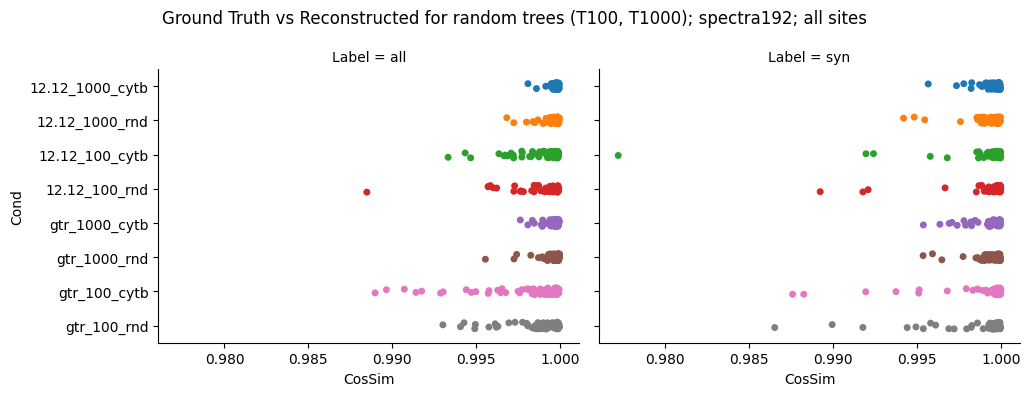

In [103]:
g = sns.catplot(x="CosSim", y="Cond", col="Label",
                data=sims, kind="strip",
                height=4, aspect=1.3);
g.fig.suptitle(f"Ground Truth vs Reconstructed for random trees (T100, T1000); spectra{nmuttypes}; all sites")
g.fig.subplots_adjust(top=0.83)
plt.xticks(np.linspace(0.98, 1, 5))
g.savefig(f"../figures/alisim/cossim_all_sites{nmuttypes}.pdf")
plt.show()

### 192 excluding inv sites

In [104]:
nmuttypes = 192
param_rates = ""

data_rec  = []
data_gt  = []
for d in tqdm.tqdm(glob.glob("../data/alisim/spectra_reconstructed_sp" + param_rates + "/*")):
    elabel = d.split("/")[-1]
    path_to_rec = os.path.join(d, "mutspec_tables/ms{}{}_iqtree.tsv")
    path_to_gt = f"../data/alisim/spectra_groundtruth_sp{param_rates}/{elabel}/mutspec{nmuttypes}.tsv"
    
    if not os.path.exists(path_to_gt):
        # print(f"{elabel}:\n\t'{path_to_gt}' doesn't exist")
        pass
    elif not os.path.exists(path_to_rec.format(nmuttypes, "syn")):
        # print(f"{elabel}:\n\t'{path_to_rec.format('syn')}' doesn't exist")
        pass
    else:
        rec = pd.concat([
            pd.read_csv(path_to_rec.format(nmuttypes, "syn"), sep="\t").assign(Label="syn"),
            pd.read_csv(path_to_rec.format(nmuttypes, "all"), sep="\t").assign(Label="all"),
        ], ignore_index=True)
        gt = pd.read_csv(path_to_gt, sep="\t")
        gt = gt[gt.Label.isin(["all", "syn"])]\
            .groupby(["Label", "Mut"]).agg({"ObsNum": np.sum, "ExpNum": np.mean})
        gt["MutSpec"] = gt["ObsNum"]  / gt["ExpNum"]
        gt["MutSpec"] = gt["MutSpec"] / gt["MutSpec"].sum()

        rec = rec.assign(RawCond=elabel)
        gt = gt.reset_index().assign(RawCond=elabel)[rec.columns]
        data_rec.append(rec)
        data_gt.append(gt)

        # cossim = 1 - cosine(spectra.MutSpec_rec, spectra.MutSpec_gt)
        # eucdist = euclidean(spectra.MutSpec_rec, spectra.MutSpec_gt)
        # mdl, tree, aln, _, replica = elabel.split("_")
        # data.append((mdl, tree, aln, replica, cossim, eucdist, elabel))

100%|██████████| 800/800 [03:46<00:00,  3.53it/s]


In [105]:
df_rec = pd.concat(data_rec)
df_gt = pd.concat(data_gt)

_indexes = ["RawCond", "Label", "Mut"]
both_spectra = df_rec.merge(df_gt, on=_indexes, suffixes=["_rec", "_gt"])
both_spectra = both_spectra[_indexes + ['ObsNum_gt', 'ObsNum_rec','ExpNum_gt', 'ExpNum_rec', 'MutSpec_gt', 'MutSpec_rec']]

_df = both_spectra[
    (both_spectra.ExpNum_rec > 1) & (both_spectra.ExpNum_gt > 1) &
    (both_spectra.ObsNum_rec > 1) & (both_spectra.ObsNum_gt > 1)
].set_index(_indexes)

spectra_rec_wide = complete_sbs192_columns(_df.MutSpec_rec.unstack().fillna(0.))
spectra_gt_wide = complete_sbs192_columns(_df.MutSpec_gt.unstack().fillna(0.))

# obs_rec_wide = df_rec.set_index(["RawCond", "Label", "Mut"]).ObsNum.unstack().fillna(0.)
# obs_gt_wide = df_gt.set_index(["RawCond", "Label", "Mut"]).ObsNum.unstack().fillna(0.)

In [106]:
sims = get_cossim(spectra_gt_wide, spectra_rec_wide).rename("CosSim").reset_index()
sims["Cond"] = sims.RawCond.str.replace("_replica_\d{1,2}", "")
sims.head()

,RawCond,Label,CosSim,Cond
0,12.12_1000_cytb_replica_0,all,0.999536,12.12_1000_cytb
1,12.12_1000_cytb_replica_0,syn,0.999419,12.12_1000_cytb
2,12.12_1000_cytb_replica_1,all,0.991392,12.12_1000_cytb
3,12.12_1000_cytb_replica_1,syn,0.998894,12.12_1000_cytb
4,12.12_1000_cytb_replica_10,all,0.999281,12.12_1000_cytb


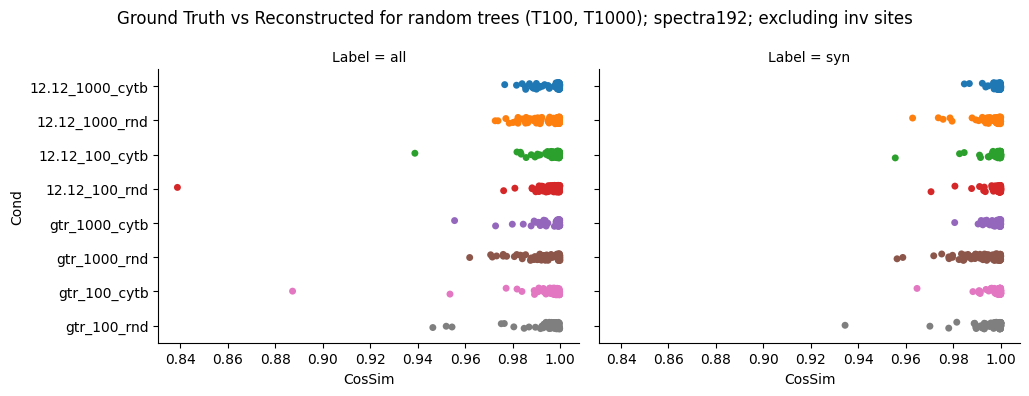

In [111]:
g = sns.catplot(x="CosSim", y="Cond", col="Label",
                data=sims, kind="strip",
                height=4, aspect=1.3);
g.fig.suptitle(f"Ground Truth vs Reconstructed for random trees (T100, T1000); spectra{nmuttypes}; excluding inv sites")
g.fig.subplots_adjust(top=0.83)
plt.xticks(np.linspace(0.84, 1, 9))
g.savefig(f"../figures/alisim/cossim_ex_cat2_sites{nmuttypes}.pdf")
plt.show()

In [108]:
cutoff = 0.95
sims[f"cossim > {cutoff}"] = sims.CosSim > cutoff
sims.groupby(["Cond", "Label"])[f"cossim > {cutoff}"].value_counts().unstack().fillna(0).T

Cond          12.12_1000_cytb        12.12_1000_rnd        12.12_100_cytb  \
Label                     all    syn            all    syn            all   
cossim > 0.95                                                               
False                     0.0    0.0            0.0    0.0            1.0   
True                    100.0  100.0          100.0  100.0           99.0   

Cond                 12.12_100_rnd        gtr_1000_cytb        gtr_1000_rnd  \
Label            syn           all    syn           all    syn          all   
cossim > 0.95                                                                 
False            0.0           1.0    0.0           0.0    0.0          0.0   
True           100.0          99.0  100.0         100.0  100.0        100.0   

Cond                 gtr_100_cytb        gtr_100_rnd        
Label            syn          all    syn         all   syn  
cossim > 0.95                                               
False            0.0          1.0    0.0         1.0   1.0  
True           100.0         99.0  100.0        99.0  98.0

## Mammals tree

### Preprocess data

In [49]:
data_rec12  = []
data_gt12   = []
data_rec192 = []
data_gt192  = []

colnames = ['Mut', 'ObsNum', 'ExpNum', 'MutSpec', 'AltNode', 'Label']
dtypes = {
    'ObsNum': np.float32,
    'ExpNum': np.float32,
    'MutSpec': np.float32,
}
i = 0

internal_mapping = {f"Node{x}":f"Node{x}" for x in range(5000)}
name2id = None
all_mappings = []

for d in tqdm.tqdm(glob.glob("../data/alisim/spectra_reconstructed_mam/*")):
    i += 1
    cond = d.split("/")[-1]
    path_to_rec12  = os.path.join(d, "mutspec_tables/mutspec12.tsv")
    path_to_rec192 = os.path.join(d, "mutspec_tables/mutspec192.tsv")
    path_to_gt12   = f"../data/alisim/spectra_groundtruth_mam/{cond}/mutspec12.tsv"
    path_to_gt192  = f"../data/alisim/spectra_groundtruth_mam/{cond}/mutspec192.tsv"
    path_to_mapping = os.path.join(d, "sequences/species_mapping.txt")

    if os.path.exists(path_to_mapping):
        name2id_leaves = pd.read_csv(path_to_mapping, header=None, index_col=1, sep="\t")[0].to_dict()
        name2id = dict(**internal_mapping, **name2id_leaves)
        all_mappings.append(name2id)
    else:
        continue

    if os.path.exists(path_to_gt12) and os.path.exists(path_to_rec12):
        rec12  = pd.read_csv(path_to_rec12, sep="\t", usecols=colnames, dtype=dtypes).assign(RawCond=cond)
        gt12   = pd.read_csv(path_to_gt12,  sep="\t", usecols=colnames, dtype=dtypes).assign(RawCond=cond)
        # gt12["AltNode"] = gt12.AltNode.map(name2id)
        
        data_rec12.append(rec12)
        data_gt12.append(gt12)

    if os.path.exists(path_to_gt192) and os.path.exists(path_to_rec192):
        rec192 = pd.read_csv(path_to_rec192, sep="\t", usecols=colnames, dtype=dtypes).assign(RawCond=cond)
        gt192  = pd.read_csv(path_to_gt192,  sep="\t", usecols=colnames, dtype=dtypes).assign(RawCond=cond)
        # gt192["AltNode"] = gt192.AltNode.map(name2id)

        data_rec192.append(rec192)
        data_gt192.append(gt192)
    
    # if i == 1:
    #     break


# check that all nodes names mappings are equal 
for x in all_mappings:
    assert x == all_mappings[0]

100%|██████████| 200/200 [21:47<00:00,  6.54s/it]


In [50]:
gt12   = pd.concat(data_gt12)
rec12  = pd.concat(data_rec12)
gt192  = pd.concat(data_gt192)
rec192 = pd.concat(data_rec192)

In [51]:
# replace encoded node names
gt12["AltNode"] = gt12.AltNode.map(name2id)
gt192["AltNode"] = gt192.AltNode.map(name2id)

In [52]:
gt12.head()

,Mut,ObsNum,ExpNum,MutSpec,AltNode,Label,RawCond
0,A>C,10.0,325.0,0.107685,OUTGRP,all,gtr_mam_cytb_replica_18
1,A>G,8.0,325.0,0.086148,OUTGRP,all,gtr_mam_cytb_replica_18
2,A>T,5.0,325.0,0.053843,OUTGRP,all,gtr_mam_cytb_replica_18
3,C>A,26.0,390.0,0.233318,OUTGRP,all,gtr_mam_cytb_replica_18
4,C>G,8.0,390.0,0.071790,OUTGRP,all,gtr_mam_cytb_replica_18


In [53]:
gt12.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44253648 entries, 0 to 222551
Data columns (total 7 columns):
 #   Column   Dtype  
---  ------   -----  
 0   Mut      object 
 1   ObsNum   float32
 2   ExpNum   float32
 3   MutSpec  float32
 4   AltNode  object 
 5   Label    object 
 6   RawCond  object 
dtypes: float32(3), object(4)
memory usage: 2.1+ GB


In [54]:
gt192.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 708058368 entries, 0 to 3560831
Data columns (total 7 columns):
 #   Column   Dtype  
---  ------   -----  
 0   Mut      object 
 1   ObsNum   float32
 2   ExpNum   float32
 3   MutSpec  float32
 4   AltNode  object 
 5   Label    object 
 6   RawCond  object 
dtypes: float32(3), object(4)
memory usage: 34.3+ GB


### Run and analyse

In [55]:
#filter out low numbers of mutations
rec12 = rec12[(rec12.ObsNum > 1) & (rec12.ExpNum > 1)]
rec192 = rec192[(rec192.ObsNum > 1) & (rec192.ExpNum > 1)]

In [56]:
gt12_wide_spectra = gt12.set_index(["RawCond", "Label", "AltNode", "Mut"]).MutSpec.unstack()
rec12_wide_spectra = rec12.set_index(["RawCond", "Label", "AltNode", "Mut"]).MutSpec.unstack()
gt192_wide_spectra = gt192.set_index(["RawCond", "Label", "AltNode", "Mut"]).MutSpec.unstack()
rec192_wide_spectra = rec192.set_index(["RawCond", "Label", "AltNode", "Mut"]).MutSpec.unstack()

In [67]:
gt12_wide_spectra = gt12.set_index(["RawCond", "Label", "AltNode", "Mut"]).ObsNum.unstack()
rec12_wide_spectra = rec12.set_index(["RawCond", "Label", "AltNode", "Mut"]).ObsNum.unstack()
gt192_wide_spectra = gt192.set_index(["RawCond", "Label", "AltNode", "Mut"]).ObsNum.unstack()
rec192_wide_spectra = rec192.set_index(["RawCond", "Label", "AltNode", "Mut"]).ObsNum.unstack()

In [68]:
cossim12 = get_cossim(gt12_wide_spectra, rec12_wide_spectra).rename("CosSim12").reset_index()
cossim192 = get_cossim(gt192_wide_spectra, rec192_wide_spectra).rename("CosSim192").reset_index()
cossim12

,RawCond,Label,AltNode,CosSim12
0,12.12_mam_cytb_replica_0,all,Node10,0.638682
1,12.12_mam_cytb_replica_0,all,Node100,0.931220
2,12.12_mam_cytb_replica_0,all,Node1001,0.982177
3,12.12_mam_cytb_replica_0,all,Node1002,0.896643
4,12.12_mam_cytb_replica_0,all,Node1003,0.617048
...,...,...,...,...
3024513,gtr_mam_rnd_replica_9,syn,RN_995,0.943510
3024514,gtr_mam_rnd_replica_9,syn,RN_996,0.999560
3024515,gtr_mam_rnd_replica_9,syn,RN_997,0.975544
3024516,gtr_mam_rnd_replica_9,syn,RN_998,0.958753


In [69]:
cossim12["mdl"] = cossim12.RawCond.apply(lambda x: x.split("_")[0])
cossim12["seq"] = cossim12.RawCond.apply(lambda x: x.split("_")[2])
cossim12["replica"] = cossim12.RawCond.apply(lambda x: x.split("_")[-1])

cossim192["mdl"] = cossim192.RawCond.apply(lambda x: x.split("_")[0])
cossim192["seq"] = cossim192.RawCond.apply(lambda x: x.split("_")[2])
cossim192["replica"] = cossim192.RawCond.apply(lambda x: x.split("_")[-1])

In [70]:
cossim12[(cossim12.mdl == "gtr") & (cossim12.seq == "rnd")]

,RawCond,Label,AltNode,CosSim12,mdl,seq,replica
2245249,gtr_mam_rnd_replica_0,all,Node10,0.634077,gtr,rnd,0
2245250,gtr_mam_rnd_replica_0,all,Node100,0.930359,gtr,rnd,0
2245251,gtr_mam_rnd_replica_0,all,Node1000,0.958769,gtr,rnd,0
2245252,gtr_mam_rnd_replica_0,all,Node1001,0.970820,gtr,rnd,0
2245253,gtr_mam_rnd_replica_0,all,Node1002,0.894427,gtr,rnd,0
...,...,...,...,...,...,...,...
3024513,gtr_mam_rnd_replica_9,syn,RN_995,0.943510,gtr,rnd,9
3024514,gtr_mam_rnd_replica_9,syn,RN_996,0.999560,gtr,rnd,9
3024515,gtr_mam_rnd_replica_9,syn,RN_997,0.975544,gtr,rnd,9
3024516,gtr_mam_rnd_replica_9,syn,RN_998,0.958753,gtr,rnd,9


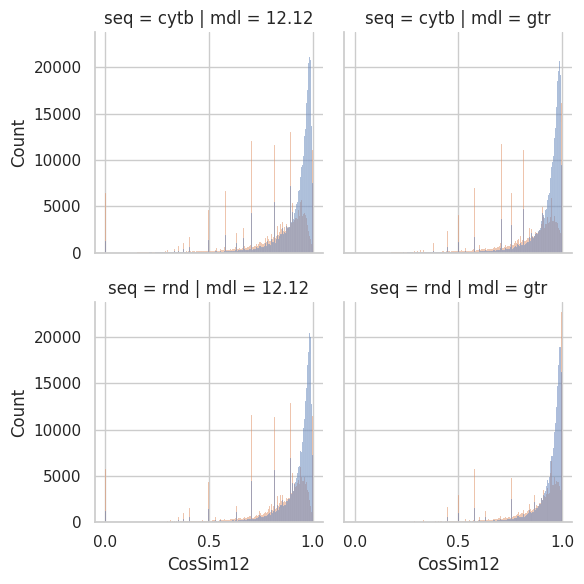

In [71]:
g = sns.FacetGrid(cossim12, col="mdl", row="seq")
g.map_dataframe(sns.histplot, x="CosSim12", hue="Label")

In [ ]:
# sns.catplot(
#     data=cossim12, col="mdl", row="seq", y="CosSim12", hue="Label",
#     kind="violin", split=False
# )

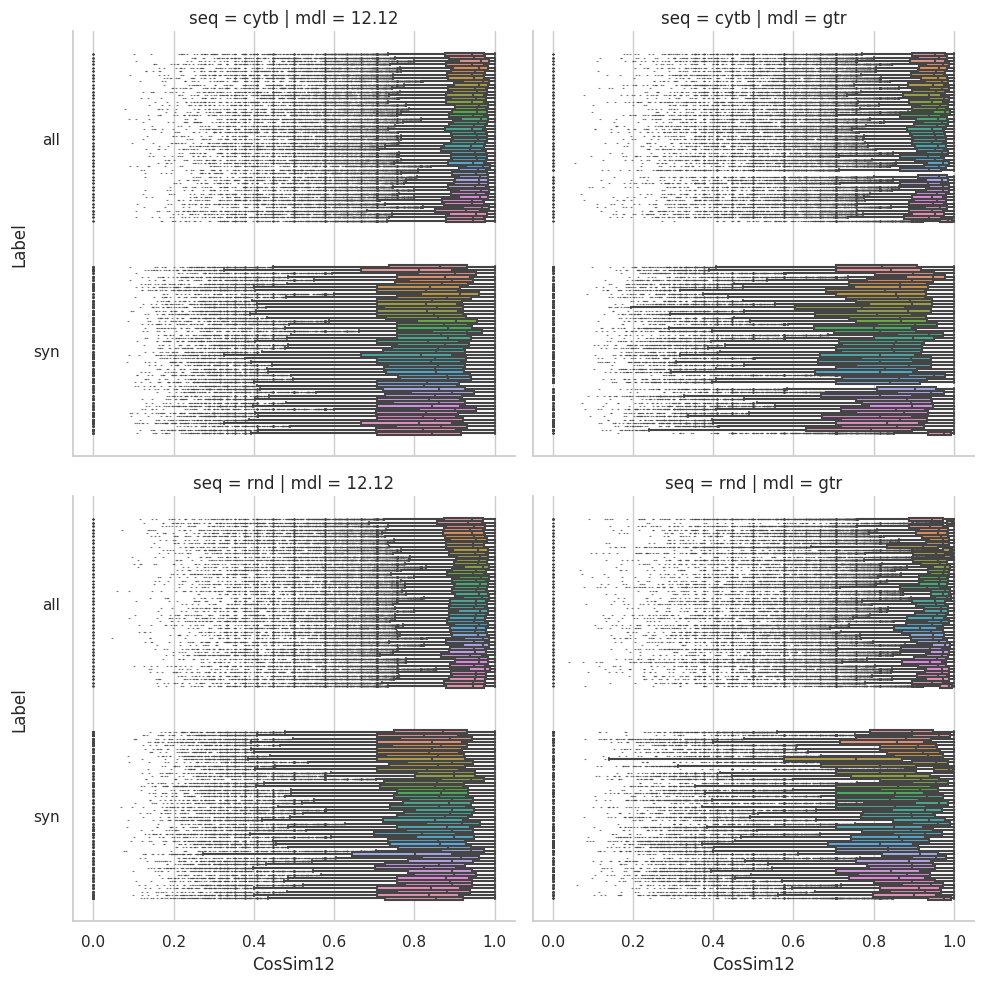

In [72]:
g = sns.catplot(data=cossim12, x="CosSim12", hue="replica", y="Label", col="mdl", row="seq", kind="box", fliersize=0.2, legend=False)

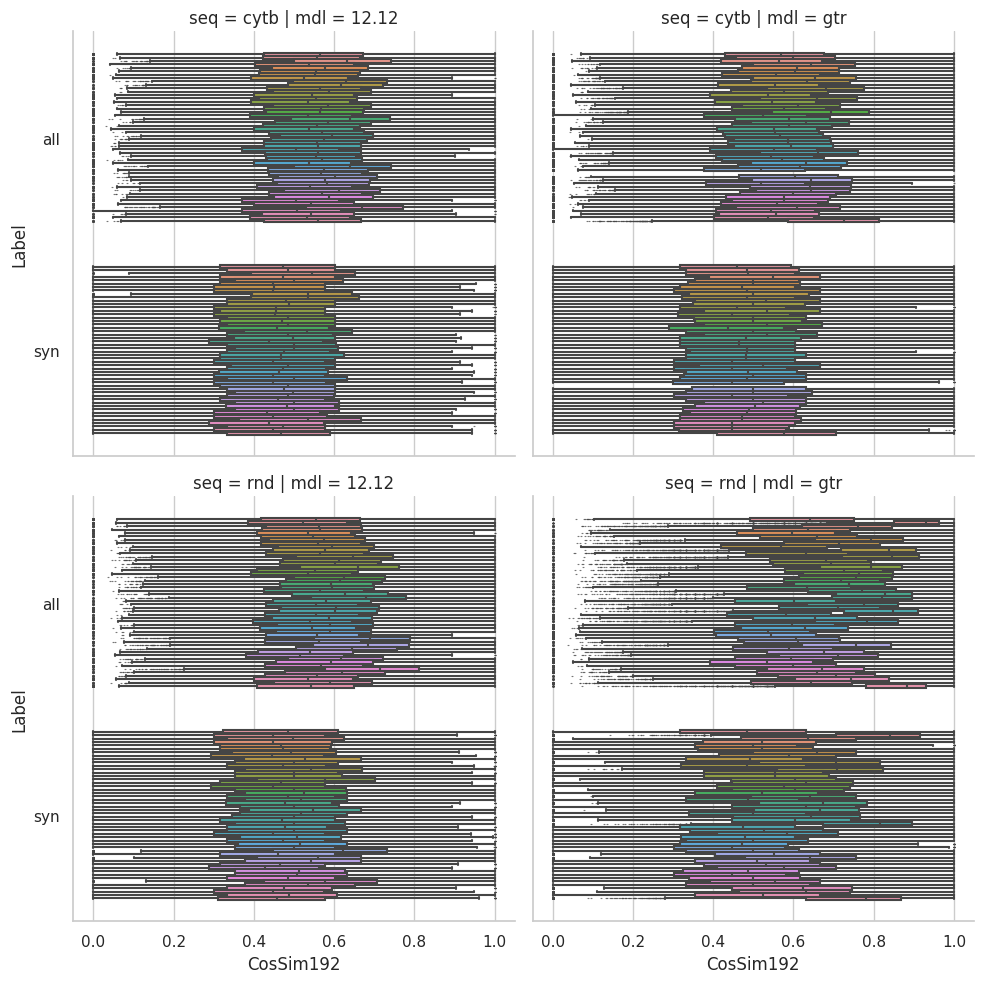

In [73]:
g = sns.catplot(data=cossim192, x="CosSim192", hue="replica", y="Label", col="mdl", row="seq", kind="box", fliersize=0.2, legend=False)